## The Kuznetsov-Plykin attractor - a classic example of chaos

$u_{n+1} = F(u_n, s )$

In [2]:
%matplotlib inline
from numpy import *
import sys
sys.path.insert(0, '../examples')
import kuznetsov_poincare as kp
sys.path.insert(0,'../src')
import map_sens as map_sens
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
rcParams['lines.linewidth'] = 2
rcParams['axes.titlesize'] = 24
rcParams['axes.labelsize'] = 20
rcParams['lines.markersize'] = 20
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = 24

# 1. Obtain a long primal trajectory, or,
# equivalently, a large number of samples distributed according to $\mu$

In [3]:
solver = kp.Solver()
n_steps = 800
s3_map = map_sens.Sensitivity(solver,n_steps)
n_runup = s3_map.n_runup

u_init = solver.u_init
s0 = solver.s0
state_dim = solver.state_dim
param_dim = s0.size
u_init = solver.primal_step(u_init, s0, n_runup)
u_trj = s3_map.solve_primal(solver,\
            solver.u_init, n_steps, solver.s0)

## Visualizing the attractor    

In [4]:
theta = arccos(u_trj.T[2])
phi = arctan2(u_trj.T[0], u_trj.T[1])


Text(0, 0.5, '$ \theta$')

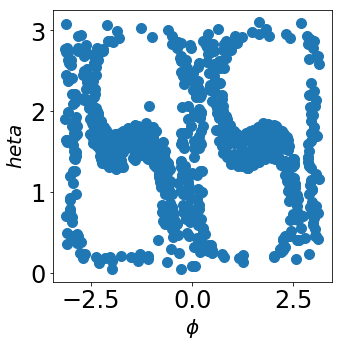

In [5]:
fig = figure(figsize=[5,5])
ax = fig.add_subplot(111)
ax.plot(phi, theta, '.')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$ \theta$')

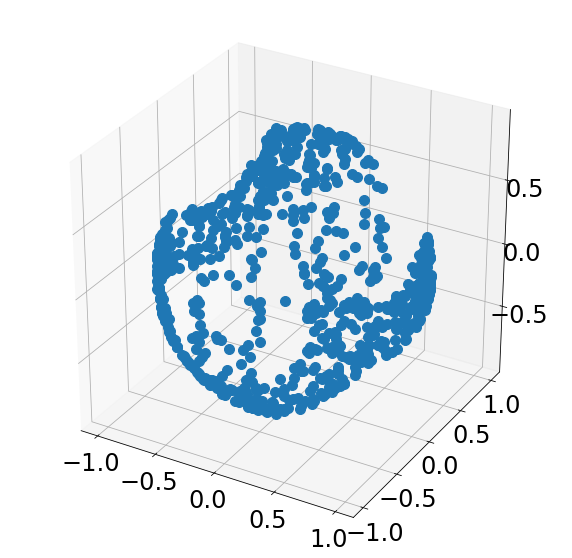

In [6]:
fig = figure(figsize=[10,10])
ax = fig.add_subplot(111,projection='3d')
x_trj = u_trj.T[0]
y_trj = u_trj.T[1]
z_trj = u_trj.T[2]
ax.plot(x_trj, y_trj, z_trj,'.')

# 2. Obtain the unstable tangent subspace at every point
Here, it is one-dimensional

In [7]:
v0_init = rand(state_dim)
v0_init /= linalg.norm(v0_init)
v0 = s3_map.solve_unstable_direction(solver, u_trj, v0_init, n_steps, s0)

## Visualize unstable tangent directions

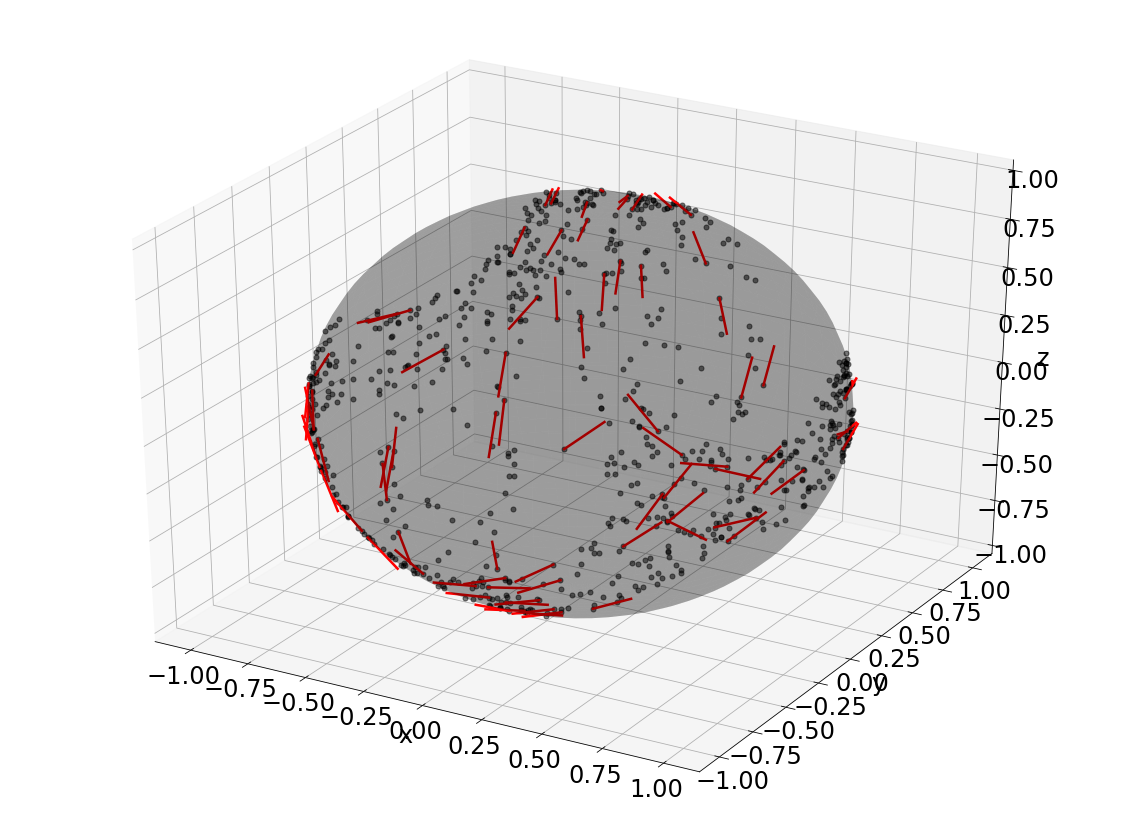

In [8]:
from driver_map_algorithm import *
fig, ax = plot_tangent_vectors_3D(u_trj, v0)

## 3. Obtain the unstable adjoint subspaces at every point 
Here it is one-dimensional

In [9]:
w0_init = rand(state_dim)
w0_init /= linalg.norm(w0_init)
w0 = s3_map.solve_unstable_adjoint_direction(solver, u_trj, w0_init, n_steps, s0)

## Visualize unstable adjoint direction

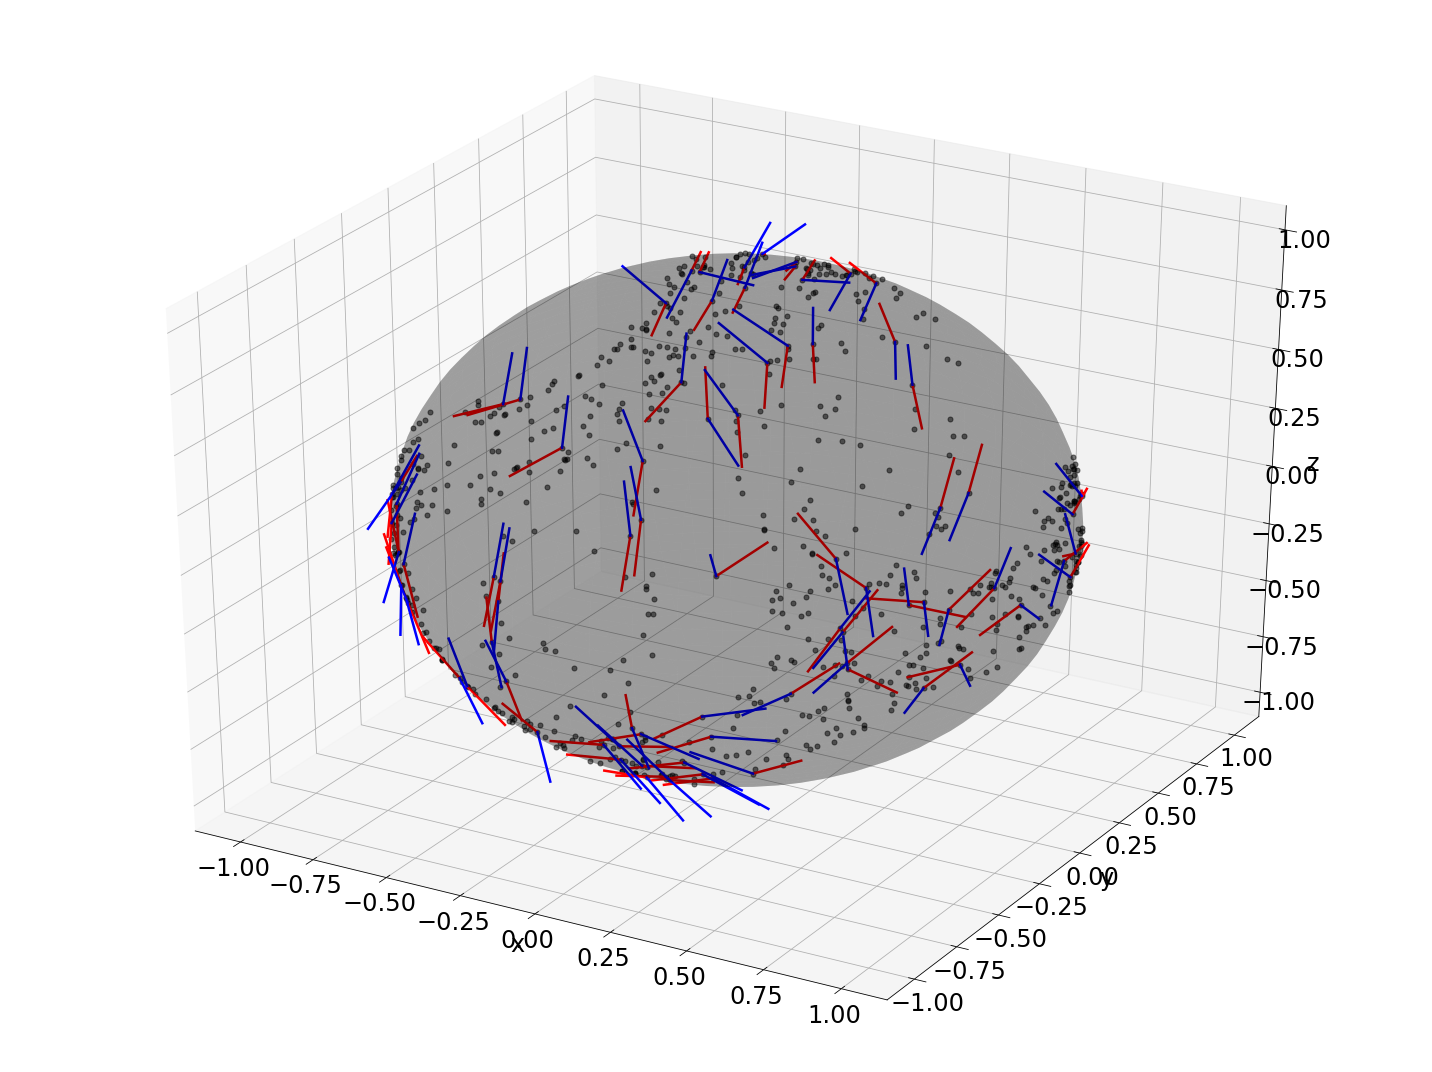

In [10]:
fig, ax = plot_tangent_and_adjoint_vectors_3D(u_trj,v0,w0)

### Define objective function and parameters

In [11]:
s0 = solver.s0
n_points_theta = 20
n_points_phi = 20
J = s3_map.compute_objective(solver, u_trj, s0, n_steps, n_points_theta, n_points_phi)
DJ = s3_map.compute_gradient_objective(solver, u_trj, s0, n_steps, n_points_theta, n_points_phi)
    

## 3. Precompute source terms of the tangent equation and the forward adjoint equation

* The tangent equation:

    $v_{n+1} = DF(u_n) v_n + (\partial_s F)(u_n)$

* The forward adjoint equation:

    $w_{n+1} = DF^{-T}(u_n) w_n - \nabla \cdot (D F)^{-1} (u_n)$

In [12]:
source_tangent = s3_map.compute_source_tangent(solver, u_trj, n_steps, s0)[:,0,:] 
source_forward_adjoint = s3_map.compute_source_forward_adjoint(solver, u_trj, n_steps, s0)
unstable_sensitivity_source = s3_map.compute_source_sensitivity(solver,u_trj,n_steps,s0)[:,0]


## 4. Solving for the stable and unstable contribution using Monte-Carlo 

In [13]:
n_runup_forward_adjoint = 10
dJds_stable, dJds_unstable, a, b = \
s3_map.compute_sensitivity(solver, u_trj, solver.s0, v0, w0, J, DJ, source_tangent,unstable_sensitivity_source,source_forward_adjoint, n_steps, n_runup_forward_adjoint)

### Visualize computed sensitivity

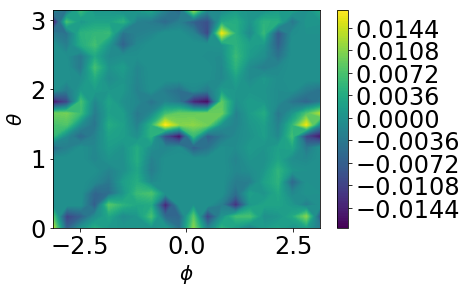

In [14]:
dJds = dJds_stable + dJds_unstable
theta = linspace(0,pi,n_points_theta)
phi = linspace(-pi,pi,n_points_phi)
figure()
contourf(phi,theta,dJds_stable,100)
xlabel(r"$\phi$")
ylabel(r"$\theta$")
colorbar()